In [5]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [6]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

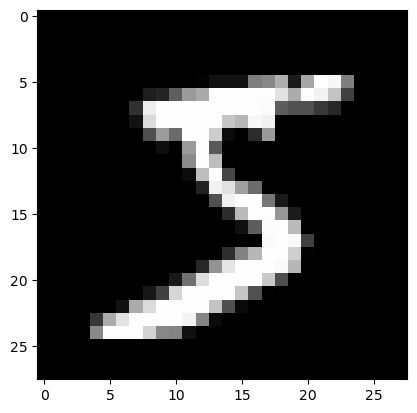

(50000, 784)


In [7]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
# ``pyplot.show()`` only if not on Colab
try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)

In [8]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [11]:
import torch.nn.functional as F
from torch import Tensor
import math

In [12]:
#Create weights/bias and initialize them with 
#Xavier initialisation http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
weights : torch.Tensor = torch.rand(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [149]:
loss_func : F.cross_entropy = F.cross_entropy

def self (xb : Tensor) -> Tensor:
    return xb @ weights + bias

#define an accuracy function
def accuracy(out: torch.Tensor, yb : torch.Tensor) -> float :
    #we get a 2 dimensial tensor and want to get the max from the columns
    preds = torch.argmax(out, dim=1)
    #compare the with the labels
    accu = preds == yb
 #   print(accu.float())
    return accu.float().mean()

In [22]:
bs = 64
xb : Tensor = x_train[0:bs]
yb : Tensor = y_train[0:bs]

loss = loss_func(self(xb=xb), yb)
accu = accuracy(self(xb), yb)

In [24]:
print(loss)
print(accu)

tensor(2.3081, grad_fn=<NllLossBackward0>)
tensor(0.1562)


In [68]:
from torch import nn


class Mnist_Logistic(nn.Module):
    def __init__(self, epochs : int = 10, bs : int = 64, lr : float = 0.15):
        super().__init__()
        self.weights = nn.Parameter(torch.rand(784,10)/math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        self.epochs : int = epochs
        self.bs : int = bs
        self.lr : float = lr
        
        
    def forward(self, xb : Tensor) -> Tensor:
        return xb @ self.weights + self.bias
    
    def fit(self ):
        
        for epoch in range(self.epochs):
            for i in range((n - 1) // self.bs + 1):
                start_i = self.bs*i
                end_i = start_i + self.bs
                xb = x_train[start_i: end_i]
                yb = y_train[start_i: end_i]
                
                pred = self(xb)
                loss = loss_func(pred, yb)
                loss.backward()
                
                with torch.no_grad():
                    for p in self.parameters():
                        p -= p.grad * self.lr
                    self.zero_grad()

In [69]:
model = Mnist_Logistic()
loss = loss_func(model(xb=xb), yb)
accu = accuracy(model(xb), yb)
print(loss)
print(accu)

tensor(2.2901, grad_fn=<NllLossBackward0>)
tensor(0.1562)


In [70]:
#model = Mnist_Logistic()

model.fit()
loss = loss_func(model(xb), yb)
accu = accuracy(model(xb), yb)
print(loss)
print(accu)

tensor(0.1721, grad_fn=<NllLossBackward0>)
tensor(0.9531)


In [91]:
from torch import optim

class Mnist_Logistic2(nn.Module):
    def __init__(self, epochs : int = 10, bs : int = 64, lr : float = 0.5) -> None:
        super().__init__()
        self.lin : nn.Linear = nn.Linear(784, 10)
        self.optimizer : optim.SGD = optim.SGD(self.parameters(), lr=lr) 
        self.epochs : int = epochs
        self.bs : int = bs
        self.lr : float = lr
        
    def forward(self, xb):
        return self.lin(xb)
    
    def fit(self ):
        
        for epoch in range(self.epochs):
            for i in range((n - 1) // self.bs + 1):
                start_i = self.bs*i
                end_i = start_i + self.bs
                xb = x_train[start_i: end_i]
                yb = y_train[start_i: end_i]
                
                pred = self(xb)
                loss = loss_func(pred, yb)
                loss.backward()
                
                self.optimizer.step()
                self.zero_grad()

In [92]:
model = Mnist_Logistic2()
loss = loss_func(model(xb), yb)
print(loss)
model.fit()
loss = loss_func(model(xb), yb)
print(loss)

tensor(2.3308, grad_fn=<NllLossBackward0>)
tensor(0.1654, grad_fn=<NllLossBackward0>)


In [111]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)


In [105]:
class Mnist_Logistic3(nn.Module):
    def __init__(self, epochs : int = 10, bs : int = 64, lr : float = 0.5) -> None:
        super().__init__()
        self.lin : nn.Linear = nn.Linear(784, 10)
        self.optimizer : optim.SGD = optim.SGD(self.parameters(), lr=lr) 
        self.epochs : int = epochs
        self.bs : int = bs
        self.lr : float = lr
        
    def forward(self, xb):
        return self.lin(xb)
    
    def fit(self ):
        
        for epoch in range(self.epochs):
            print(f'epoch {self.epochs} of {epoch}')
            for i in range((n - 1) // self.bs + 1):
                if i % 200 == 0 and i > 0:
                    print(f' {self.bs*i / n * 100}% loaded')
                #batch weises laden
                xb, yb = train_ds[bs*i:bs*i+bs]
                #batchweises predicten (Vektor batches x traindata)
                pred = self(xb)
                loss = loss_func(pred, yb)
                loss.backward()
                
                self.optimizer.step()
                self.zero_grad()

In [106]:
model = Mnist_Logistic3()
loss = loss_func(model(xb), yb)
print(loss)
model.fit()
loss = loss_func(model(xb), yb)
print(loss)

tensor(2.3368, grad_fn=<NllLossBackward0>)
epoch 10 of 0
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 1
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 2
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 3
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 4
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 5
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 6
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 7
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 8
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 9
 25.6% loaded
 51.2% loaded
 76.8% loaded
tensor(0.1649, grad_fn=<NllLossBackward0>)


#Now we use a DataLoader to get the batches

In [107]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [108]:
#With DataLoader
class Mnist_Logistic4(nn.Module):
    def __init__(self, epochs : int = 10, bs : int = 64, lr : float = 0.5) -> None:
        super().__init__()
        self.lin : nn.Linear = nn.Linear(784, 10)
        self.optimizer : optim.SGD = optim.SGD(self.parameters(), lr=lr) 
        self.epochs : int = epochs
        self.bs : int = bs
        self.lr : float = lr
        
    def forward(self, xb):
        return self.lin(xb)
    
    def fit(self ):
        
        for epoch in range(self.epochs):
            print(f'epoch {self.epochs} of {epoch}')
            for xb, yb in train_dl:
                # if i % 200 == 0 and i > 0:
                #     print(f' {self.bs*i / n * 100}% loaded')
                #batch weises laden
                # xb, yb = train_ds[bs*i:bs*i+bs]
                #batchweises predicten (Vektor batches x traindata)
                pred = self(xb)
                loss = loss_func(pred, yb)
                loss.backward()
                
                self.optimizer.step()
                self.zero_grad()

In [109]:
model = Mnist_Logistic3()
loss = loss_func(model(xb), yb)
print(loss)
model.fit()
loss = loss_func(model(xb), yb)
print(loss)

tensor(2.2725, grad_fn=<NllLossBackward0>)
epoch 10 of 0
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 1
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 2
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 3
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 4
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 5
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 6
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 7
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 8
 25.6% loaded
 51.2% loaded
 76.8% loaded
epoch 10 of 9
 25.6% loaded
 51.2% loaded
 76.8% loaded
tensor(0.1652, grad_fn=<NllLossBackward0>)


In [114]:
train_ds : TensorDataset = TensorDataset(x_train, y_train)
valid_ds : TensorDataset = TensorDataset(x_valid, y_valid)
train_dl : DataLoader = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl : DataLoader = DataLoader(valid_ds, batch_size=2*bs)


In [125]:
#With Validation Data
class Mnist_Logistic5(nn.Module):
    def __init__(self, epochs : int = 2, bs : int = 64, lr : float = 0.5) -> None:
        super().__init__()
        self.lin : nn.Linear = nn.Linear(784, 10)
        self.optimizer : optim.SGD = optim.SGD(self.parameters(), lr=lr) 
        self.epochs : int = epochs
        self.bs : int = bs
        self.lr : float = lr
        
    def forward(self, xb):
        return self.lin(xb)
    
    def fit(self):
        for epoch in range(self.epochs):
#            print(f'epoch {self.epochs} of {epoch}')
            for xb, yb in train_dl:
                self.train()
                pred = self(xb)
                loss = loss_func(pred, yb)
                loss.backward()
                
                self.optimizer.step()
                self.zero_grad()
            self.eval()
            
            with torch.no_grad():
                valid_loss = sum(loss_func(self(xv), yv) for xv, yv in valid_dl)
            print(epoch, valid_loss / len(valid_dl))

In [126]:
model = Mnist_Logistic5()
loss = loss_func(model(xb), yb)
print(loss)
model.fit()
loss = loss_func(model(xb), yb)
print(loss)

tensor(2.2909, grad_fn=<NllLossBackward0>)
0 tensor(0.2965)
1 tensor(0.6380)
tensor(0.5559, grad_fn=<NllLossBackward0>)


In [151]:
len(valid_dl)*2*64

10112

In [147]:
l : list = [1,2]
l2 : list = ['a', 'b']
for a, b in zip(l, l2):
    print(*next(zip([a],[b])))
    print(a, b)

1 a
1 a
2 b
2 b


In [167]:
#With optimization
class Mnist_Logistic6(nn.Module):
    def __init__(self, epochs : int = 2, bs : int = 64, lr : float = 0.5) -> None:
        super().__init__()
        self.lin : nn.Linear = nn.Linear(784, 10)
        self.optimizer : optim.SGD = optim.SGD(self.parameters(), lr=lr) 
        self.loss_func : F.cross_entropy = F.cross_entropy
        self.epochs : int = epochs
        self.bs : int = bs
        self.lr : float = lr
        
    def forward(self, xb):
        return self.lin(xb)
    
    def loss_batch(self, xb : Tensor, yb: Tensor, opt : optim.Optimizer = None) :
        """_summary_

        Args:
            xb (Tensor): _description_
            yb (Tensor): _description_
            opt (optim.Optimizer, optional): _description_. Defaults to None.

        Returns:
            float, int : loss and len of  a batch
        """
        loss :F.cross_entropy = self.loss_func(self(xb), yb)

        if opt is not None :
            loss.backward()
            opt.step()
            opt.zero_grad()
        return loss.item(), len(xb)
    
    def fit(self):
        for epoch in range(self.epochs):
#            print(f'epoch {self.epochs} of {epoch}')
            self.train()
            for xb, yb in train_dl:
                #train modus
                loss = self.loss_batch(xb, yb, self.optimizer)
            
            #model swithcing
            self.eval()
            with torch.no_grad():
                valid_loss, nums = zip(* [self.loss_batch(xv, yv) for xv, yv in valid_dl])
            print(epoch, np.sum(np.multiply(valid_loss, nums)) / np.sum(nums))

In [168]:
model = Mnist_Logistic6()
loss = loss_func(model(xb), yb)
print(loss)
model.fit()
loss = loss_func(model(xb), yb)
print(loss)

tensor(2.3059, grad_fn=<NllLossBackward0>)
0 0.31070893892645834
1 0.2960463997244835
tensor(0.1413, grad_fn=<NllLossBackward0>)


In [153]:
x1

array([[0., 1., 2.],
       [3., 4., 5.],
       [6., 7., 8.]])

In [154]:
x2

array([0., 1., 2.])